In [2]:
def _make_report_header(maxN):
    """Return the header and format string for reporting coverage."""
    nw = len(str(maxN))
    frac_width = 2*nw + 1  # width of 300/1000
    frac_header = 'Sample'
    frac_format = '{i:' + str(nw) + 'd}/{n:' + str(nw) + 'd}'
    if frac_width < len(frac_header):
        pad = ''.join([' ' for _ in range(len(frac_header) - frac_width)])
        frac_format = pad + frac_format
    elif len(frac_header) < frac_width:
        pad = ''.join([' ' for _ in range(frac_width - len(frac_header))])
        frac_header = pad + frac_header
    hdr = frac_header + "   Coverage   MinGap   Median   MaxGap     Elapsed     Remaining   Infeasible"
    fmt = frac_format + "    {cov:6.2f}%   {min:6.4f}   {med:6.4f}   {max:6.4f}   {ela:9.2f}     {rem:9.2f}   {inf:10d}"
    return hdr, fmt

def _maxgap(points, fva=None):
    # points has rows = samples, columns = variables

    # make a copy because we're going to sort the columns
    points = points.copy()
    if fva is not None:
        points = np.vstack((fva.minimum, points, fva.maximum))
    points.sort(0)

    gaps = points[1:,:] - points[0:-1,:]
    width = gaps.max(0)
    loc = gaps.argmax(0)
    left = np.zeros(width.size)
    for i in range(width.size):
        left[i] = points[loc[i],i]
    relative = width / (points[-1,:] - points[0,:])
    target = left + width/2

    return relative, target, width

#Variable optimization
def var_opt(sense_, var):
    cost_array = ['' for i in range(gen_len)]
    for z in range(gen_len):
        #Create a model
        model = ConcreteModel()

        model.IDX1 = range(gen_len)
        model.IDX2 = range(bus_len)
        model.Pg = Var(model.IDX2)
        model.Qg = Var(model.IDX2)
        model.t = Var(model.IDX2)
        model.v = Var(model.IDX2)
        for i in model.IDX2:
            model.Pg[i].fix(0) 
            model.Qg[i].fix(0) 

        for i in model.IDX1:
            model.Pg[gen['bus'][i]-1].fixed = False
            model.Qg[gen['bus'][i]-1].fixed = False


        # declare constraints
        model.c = ConstraintList()

        for i in range(bus_len):
            model.c.add(expr = model.Pg[i] <= Pmax[i])
            model.c.add(expr = model.Pg[i] >= Pmin[i])
            model.c.add(expr = model.v[i] <= Vmax[i])
            model.c.add(expr = model.v[i] >= Vmin[i])    

        #Bus voltage angle initial condition
        model.c.add(model.t[0] == 0)


        #Nodal equations
        for i in range(bus_len):
            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Pg[i] + Pd[i]== 0)
            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Qg[i] + Qd[i]== 0)

        #Line flow constraints
        for i in range(len(branch)): 
            x = int(branch.loc[i]['fbus'])-1
            y = int(branch.loc[i]['tbus'])-1
            val = (branch.loc[i]['rateA']/100)
            if(val == 0):
                val = 100
        #    With phasor
            Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
            Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

            Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
            Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     

            model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
            model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)

        
        # declare objective
        if ((sense_=='maximize') & (var =='p')):
            model.cost = Objective( 
                expr = model.Pg[(gen['bus'][z])-1], sense=maximize
            )
        elif ((sense_=='minimize') & (var =='p')):
            model.cost = Objective( 
                expr = model.Pg[(gen['bus'][z])-1], sense=minimize)
        elif ((sense_=='maximize') & (var =='q')):
            model.cost = Objective( 
                expr = model.Qg[(gen['bus'][z])-1], sense=maximize
            )
        elif ((sense_=='minimize') & (var =='q')):
            model.cost = Objective( 
                expr = model.Qg[(gen['bus'][z])-1], sense=minimize)


        # solve
        SolverFactory('ipopt').solve(model)
        cost_array[z] = model.cost.expr.value
#         if (cost_array[z] <= 0.000001):
#             cost_array[z] = 0
    
    return np.array(cost_array)


# Case 1: Static Load
def _generate_sample(
        primary_var, primary_lb, primary_ub,
        secondary_vars=None, secondary_targets=None, secondary_weights=None):
    #Create a model
    model = ConcreteModel()
    model.t = Var(range(bus_len))
    model.v = Var(range(bus_len))

    model.vars = Var(range(len(fva)))

    model.c = ConstraintList()

    #Bus voltage angle initial condition
    model.c.add(model.t[0] == 0)

    #Limits constraints
    for i in range(gen_len):
        model.c.add(expr = model.vars[i] <= fva.iloc[i]['maximum'])
        model.c.add(expr = model.vars[i] >= fva.iloc[i]['minimum'])
        model.c.add(expr = model.vars[i+gen_len] <= fva.iloc[i+gen_len]['maximum'])
        model.c.add(expr = model.vars[i+gen_len] >= fva.iloc[i+gen_len]['minimum'])
    for i in range(bus_len):
        model.c.add(expr = model.v[i] <= Vmax[i])
        model.c.add(expr = model.v[i] >= Vmin[i]) 

    model.vars[primary_var].setlb(primary_lb)
    model.vars[primary_var].setub(primary_ub)


    if secondary_vars is not None:
        quad_exp = 0
        for i, sec in enumerate(secondary_vars):
            quad_exp += secondary_weights[i] * (model.vars[sec]-secondary_targets[i])**2

        #Nodal equations
#         count = 0
        for i in range(bus_len):
            if (np.any(gen['bus'].ravel()-1==[i])):
                holder1 = model.vars[i]
                holder2 = model.vars[i+gen_len]
#                 count = count+1
            else:
                holder1 = 0
                holder2 = 0

            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder1 +  Pd[i] == 0)
            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder2 +  Qd[i] == 0)

        #Line flow constraints
        for i in range(len(branch)): 
            x = int(branch.loc[i]['fbus'])-1
            y = int(branch.loc[i]['tbus'])-1
            val = (branch.loc[i]['rateA']/100)
            if(val == 0):
                val = 100
        #    With phasor
            Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
            Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

            Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
            Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     

            model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
            model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)


        model.cost = Objective(expr = quad_exp)
    else:
        model.cost = Objective(expr = 1)

    solution = SolverFactory('ipopt').solve(model)

    # Line flow data
    Pxyp = np.zeros(len(branch))
    Pyxp = np.zeros(len(branch))
    Qxyp = np.zeros(len(branch))
    Qyxp = np.zeros(len(branch))
    for i in range(len(branch)): 
        x = int(branch.loc[i]['fbus'])-1
        y = int(branch.loc[i]['tbus'])-1
        Pxyp[i] = (model.v[x].value**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x].value*model.v[y].value*cmath.polar(Ybus[x,y])[0]*cos(model.t[x].value-model.t[y].value-cmath.polar(Ybus[x,y])[1])
        Qxyp[i] = -(model.v[x].value**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x].value*model.v[y].value*cmath.polar(Ybus[x,y])[0]*sin(model.t[x].value-model.t[y].value-cmath.polar(Ybus[x,y])[1])     
        Pyxp[i] = (model.v[y].value**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x].value*model.v[y].value*cmath.polar(Ybus[x,y])[0]*cos(model.t[y].value-model.t[x].value-cmath.polar(Ybus[x,y])[1])
        Qyxp[i] = -(model.v[y].value**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x].value*model.v[y].value*cmath.polar(Ybus[x,y])[0]*sin(model.t[y].value-model.t[x].value-cmath.polar(Ybus[x,y])[1])     

    #Return result to the Gapsplit algorithm
    
    if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
        # Do something when the solution in optimal and feasible
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        result = np.array([model.vars[i].value for i in range(len(fva))])
        return result

    else:
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        return None


#load data
import numpy as np
import pandas as pd
import time
import cmath
from pyomo.opt import SolverFactory
from pyomo.environ import *
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

xls = pd.ExcelFile('data\case6.xlsx')
branch = pd.read_excel(xls, 'branch')
gen = pd.read_excel(xls, 'gen')
bus = pd.read_excel(xls, 'bus')
cost = pd.read_excel(xls, 'cost')
base = 100  

#Y matrix
base = 100
bus_len = bus.shape[0]
gen_len = len(gen['bus'].ravel())

Ybus = np.matrix(np.zeros([bus_len,bus_len]),dtype=complex)
shunt = np.zeros(bus_len, dtype=complex)
x = [pd.DataFrame() for i in range(bus_len)]
for i in range(bus_len):  
    x[i] = branch.loc[branch['fbus'] == i]
    fro = [j for j in x[i]['tbus']]
    fro = pd.DataFrame(fro)
    for j in range(len(fro)):
        Ybus[i-1,fro.loc[j][0]-1] =  -1/complex(pd.DataFrame(x[i]['r']).iloc[j][0],pd.DataFrame(x[i]['x']).iloc[j][0])
        Ybus[fro.loc[j][0]-1,i-1] =  -1/complex(pd.DataFrame(x[i]['r']).iloc[j][0],pd.DataFrame(x[i]['x']).iloc[j][0])
        shunt[j] = complex(0,sum(x[i]['b'])/2)

for i in range(bus_len):
    Ybus[i,i] = np.sum(Ybus[i,:])*(-1) + complex(0,sum(branch.loc[(branch['fbus']==i+1) | (branch['tbus']==i+1)]['b'])/2)


# declare variables
Pd = np.zeros(bus_len)
Qd = np.zeros(bus_len)
Vmax = np.zeros(bus_len)
Vmin = np.zeros(bus_len)
Pmax = np.zeros(bus_len)
Pmin = np.zeros(bus_len)
Qmax = np.zeros(bus_len)
Qmin = np.zeros(bus_len)
cost_lin = np.zeros(bus_len)
cost_quad = np.zeros(bus_len)

for i in range(bus_len):
    Pd[i] = bus['Pd'][i]/base
    Qd[i] = bus['Qd'][i]/base
    Vmax[i] = bus['Vmax'][i]
    Vmin[i] = bus['Vmin'][i]

for i in range(gen_len):
    k = i
    i = gen['bus'].ravel()[i]
    Pmax[i-1] = gen.loc[gen['bus'] == i]['Pmax'].ravel()[0]/base
    Pmin[i-1] = gen.loc[gen['bus'] == i]['Pmin'].ravel()[0]/base
    Qmax[i-1] = gen.loc[gen['bus'] == i]['Qmax'].ravel()[0]/base
    Qmin[i-1] = gen.loc[gen['bus'] == i]['Qmin'].ravel()[0]/base
    cost_lin[i-1] = cost['lin'][k]*base
    cost_quad[i-1] = cost['quad'][k]*base**2

p = pd.DataFrame([gen['Pmin'],gen['Pmax']]).T
p.columns = ['minimum', 'maximum']
p = p.T
p.columns = ['P%s' % (i+1) for i in range(gen_len)]
p = p.T/base

q = pd.DataFrame([gen['Qmin'],gen['Qmax']]).T
q.columns = ['minimum', 'maximum']
q = q.T
q.columns = ['Q%s' % (i+1) for i in range(gen_len)]
q = q.T/base

v = pd.DataFrame([bus['Vmin'],bus['Vmax']]).T
v.columns = ['minimum', 'maximum']
v = v.T
v.columns = ['V%s' % (i+1) for i in range(bus_len)]
v = v.T

l_p = pd.DataFrame([(Pd - 0.5*Pd),(Pd + 0.5*Pd)]).T
l_p.columns = ['minimum','maximum']
l_p = l_p.T
l_p.columns = ['Pd_%s' % (i+1) for i in range(bus_len)]
l_p = l_p.T

l_q = pd.DataFrame([(Qd - 0.5*Qd), (Qd + 0.5*Qd)]).T
l_q.columns = ['minimum','maximum']
l_q = l_q.T
l_q.columns = ['Qd_%s' % (i+1) for i in range(bus_len)]
l_q = l_q.T

# fva = pd.concat([p,q,l_p,l_q])


#Variable optimization
p_min = var_opt(sense_= 'minimize', var='p')
p_max = var_opt(sense_= 'maximize', var='p')
p = pd.DataFrame([p_min,p_max]).T
p.columns = ['minimum', 'maximum']
p = p.T
p.columns = ['P%s' % (i+1) for i in range(gen_len)]
p = p.T

q_min = var_opt(sense_= 'minimize', var='q')
q_max = var_opt(sense_= 'maximize', var='q')
q = pd.DataFrame([q_min,q_max]).T
q.columns = ['minimum', 'maximum']
q = q.T
q.columns = ['Q%s' % (i+1) for i in range(gen_len)]
q = q.T

fva = pd.concat([p,q])

In [792]:
# Appendix Case Study: Computation times

n = 20; max_tries = None; r_w = 10**6;
primary='max'; primary_tol=0.001;
secondary_frac=2;
min_range=1e-5;
enforce_range=True;
report_interval=0.5;
quiet=False

report = lambda s: print(s)

if secondary_frac >= 1.0:
    n_secondary = secondary_frac
else:
    n_secondary = np.floor(secondary_frac * len(fva)).astype(int)

idxs = (fva.maximum - fva.minimum >= min_range).to_numpy().nonzero()[0]
weights = (1/(fva.maximum - fva.minimum)**2).to_numpy()
report("Targeting {}/{} unblocked primary variables.".format(len(idxs), len(fva)))
report("Targeting {} secondary variables.".format(n_secondary))

report_header, report_format = _make_report_header(n)
report("\n" + report_header)
if report_interval < 1.0:
    report_interval = np.floor(report_interval * n).astype(int)

samples = np.zeros((r_w, len(fva)))
i_samples = np.zeros((n, len(fva)))

k = 0
infeasible_count = 0
counter = 0
true_s = 0

primary_var = -1
try_ = 0
start_time = time.time()

# var_p[ever] = np.array([])
# relative_s = ['' for i in range(100*n)]

sample_id = np.array([])

while True:
    if max_tries is not None and try_ >= max_tries:
        break
    try_ += 1

    relative, target, width = _maxgap(samples[0:k,idxs], fva.iloc[idxs,:])
#     relative_s[k] = relative
    if (counter >= 2) :
        counter = 0
        primary_var = np.random.choice(len(idxs), 1).astype(int)[0]
    else:
        primary_var = np.argmax(relative)

    primary_target = target[primary_var]
    primary_lb = primary_target - primary_tol*width[primary_var]
    primary_ub = primary_target + primary_tol*width[primary_var]
    secondary_vars = np.random.choice(len(idxs), n_secondary, replace=False)
    secondary_targets = target[secondary_vars]
    secondary_weights = weights[idxs[secondary_vars]]


    new_sample =  _generate_sample(
                idxs[primary_var], primary_lb, primary_ub,
                idxs[secondary_vars], secondary_targets, secondary_weights)

    if new_sample is not None:
        if enforce_range:
            new_sample[new_sample > fva.maximum] = fva.maximum[new_sample > fva.maximum]
            new_sample[new_sample < fva.minimum] = fva.minimum[new_sample < fva.minimum]

        samples[k,:] = new_sample
        i_samples[true_s,:] = new_sample

        sample_id = np.append(sample_id,k)
        k += 1
        true_s += 1
        #Selected primary variable
#         var_p[ever] = np.append(var_p[ever],idxs[primary_var])

        #Reporting true samples {addition}
        relative, target, width = _maxgap(i_samples[0:true_s,idxs], fva.iloc[idxs,:])
        if k % report_interval == 0:
            elapsed = time.time() - start_time
            remaining = elapsed / k * (n - k)
            report(report_format.format(
                    i=true_s, n=n, cov=100*(1-np.mean(relative)),
                    min=np.min(relative), med=np.median(relative),
                    max=np.max(relative), ela=elapsed, rem=remaining,
                    inf=infeasible_count))
    else:
#         addition for infeasible samples
        samples[k,primary_var] = target[primary_var]
        w = idxs
#         w = np.delete(w,idxs[primary_var])
        w = w[w != idxs[primary_var]]
        for i in range(len(w)):
            samples[k,w[i]] = fva['minimum'][w[i]]
        k += 1

        infeasible_count += 1
        counter += 1


    if true_s >= n: break
#     if k >= r_w: break

if true_s < n:
    # max_tries reached; return fewer than n samples
    i_samples = i_samples[:true_s,:]

if k < r_w:
    # max_tries reached; return fewer than n samples
    samples = samples[:k,:]
end_time = time.time()        

cal_time = end_time-start_time
ans = pd.DataFrame(data=samples,columns=fva.maximum.index)
t_ans = pd.DataFrame(data=i_samples,columns=fva.maximum.index)


Targeting 6/6 unblocked primary variables.
Targeting 2 secondary variables.

Sample   Coverage   MinGap   Median   MaxGap     Elapsed     Remaining   Infeasible
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
  9/20     80.45%   0.1659   0.1806   0.2433        1.85          1.85            1
 19/20     88.86%   0.0839   0.1180   0.1248        3.47          0.00            1


In [793]:
cal_time

3.6083457469940186

In [794]:
from scipy.spatial import ConvexHull
data = t_ans[:18]
variables = ['P1','Q2', 'Q3']
points = data[variables].to_numpy()
ConvexHull(points).volume

0.8408164450117612

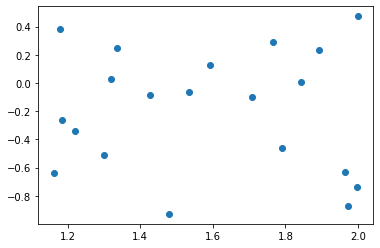

In [788]:
##Creating similar figures as 6&7 for soa
n= 20
plt.scatter(t_ans['P1'][:n],t_ans['Q3'][:n])

In [87]:
#Case Study 1: Understanding gapsplit coverage via primary and secondary variables (Using static load)

#variable for secondary variable iterations
rounds = 4
ans = ['' for i in range(rounds)]
t_ans = ['' for i in range(rounds)]
var_p = ['' for i in range(rounds)]

for ever in range(rounds):
    n = 5000; max_tries = None; r_w = 10**6;
    primary='max'; primary_tol=0.001;
    secondary_frac=ever;
    min_range=1e-5;
    enforce_range=True;
    report_interval=0.5;
    quiet=False

    report = lambda s: print(s)

    if secondary_frac >= 1.0:
        n_secondary = secondary_frac
    else:
        n_secondary = np.floor(secondary_frac * len(fva)).astype(int)

    idxs = (fva.maximum - fva.minimum >= min_range).to_numpy().nonzero()[0]
    weights = (1/(fva.maximum - fva.minimum)**2).to_numpy()
    report("Targeting {}/{} unblocked primary variables.".format(len(idxs), len(fva)))
    report("Targeting {} secondary variables.".format(n_secondary))

    report_header, report_format = _make_report_header(n)
    report("\n" + report_header)
    if report_interval < 1.0:
        report_interval = np.floor(report_interval * n).astype(int)

    samples = np.zeros((r_w, len(fva)))
    i_samples = np.zeros((n, len(fva)))

    k = 0
    infeasible_count = 0
    counter = 0
    true_s = 0

    primary_var = -1
    try_ = 0
    start_time = time.time()

    var_p[ever] = np.array([])
    # relative_s = ['' for i in range(100*n)]

    sample_id = np.array([])

    while True:
        if max_tries is not None and try_ >= max_tries:
            break
        try_ += 1

        relative, target, width = _maxgap(samples[0:k,idxs], fva.iloc[idxs,:])
    #     relative_s[k] = relative
        if (counter >= 2) :
            counter = 0
            primary_var = np.random.choice(len(idxs), 1).astype(int)[0]
        else:
            primary_var = np.argmax(relative)

        primary_target = target[primary_var]
        primary_lb = primary_target - primary_tol*width[primary_var]
        primary_ub = primary_target + primary_tol*width[primary_var]
        secondary_vars = np.random.choice(len(idxs), n_secondary, replace=False)
        secondary_targets = target[secondary_vars]
        secondary_weights = weights[idxs[secondary_vars]]


        new_sample =  _generate_sample(
                    idxs[primary_var], primary_lb, primary_ub,
                    idxs[secondary_vars], secondary_targets, secondary_weights)

        if new_sample is not None:
            if enforce_range:
                new_sample[new_sample > fva.maximum] = fva.maximum[new_sample > fva.maximum]
                new_sample[new_sample < fva.minimum] = fva.minimum[new_sample < fva.minimum]

            samples[k,:] = new_sample
            i_samples[true_s,:] = new_sample

            sample_id = np.append(sample_id,k)
            k += 1
            true_s += 1
            #Selected primary variable
            var_p[ever] = np.append(var_p[ever],idxs[primary_var])

            #Reporting true samples {addition}
            relative, target, width = _maxgap(i_samples[0:true_s,idxs], fva.iloc[idxs,:])
            if k % report_interval == 0:
                elapsed = time.time() - start_time
                remaining = elapsed / k * (n - k)
                report(report_format.format(
                        i=true_s, n=n, cov=100*(1-np.mean(relative)),
                        min=np.min(relative), med=np.median(relative),
                        max=np.max(relative), ela=elapsed, rem=remaining,
                        inf=infeasible_count))
        else:
    #         addition for infeasible samples
            samples[k,primary_var] = target[primary_var]
            w = idxs
    #         w = np.delete(w,idxs[primary_var])
            w = w[w != idxs[primary_var]]
            for i in range(len(w)):
                samples[k,w[i]] = fva['minimum'][w[i]]
            k += 1

            infeasible_count += 1
            counter += 1


        if true_s >= n: break
    #     if k >= r_w: break

    if true_s < n:
        # max_tries reached; return fewer than n samples
        i_samples = i_samples[:true_s,:]

    if k < r_w:
        # max_tries reached; return fewer than n samples
        samples = samples[:k,:]

    ans[ever] = pd.DataFrame(data=samples,columns=fva.maximum.index)
    t_ans[ever] = pd.DataFrame(data=i_samples,columns=fva.maximum.index)

for ever in range(rounds):
    var_p[ever] = var_p[ever].astype(str)
    for n, i in enumerate(var_p[ever]):
        if i == '0.0':
            var_p[ever][n] = 'P1'
        if i == '1.0':
            var_p[ever][n] = 'P2'
        if i == '2.0':
            var_p[ever][n] = 'P3'
        if i == '3.0':
            var_p[ever][n] = 'Q1'
        if i == '4.0':
            var_p[ever][n] = 'Q2'
        if i == '5.0':
            var_p[ever][n] = 'Q3'

ans_name = ['raw%s' % (i) for i in range(rounds)]
t_ans_name = ['valid%s' % (i) for i in range(rounds)]
var_p_name = ['Primary%s' % (i) for i in range(rounds)]
writer = pd.ExcelWriter('C:/Users/abuga/OneDrive/Desktop/PhD/Progress/Papers/Power_Tech_Conference/Excel data/case_study/pri_sec.xlsx')
for ever in range(rounds):
    ans[ever].to_excel(writer,ans_name[ever])
    t_ans[ever].to_excel(writer,t_ans_name[ever])
    pd.DataFrame(var_p[ever]).to_excel(writer,var_p_name[ever])
writer.save()

Targeting 6/6 unblocked primary variables.
Targeting 0 secondary variables.

   Sample   Coverage   MinGap   Median   MaxGap     Elapsed     Remaining   Infeasible
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasib

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
2451/5000     99.83%   0.0014   0.0017   0.0020      251.35        251.35           49
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

In [224]:
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
rounds = 4
#Static load data
xls = pd.ExcelFile('C:/Users/abuga/OneDrive/Desktop/PhD/Progress/Papers/Power_Tech_Conference/Excel data/case_study/pri_sec.xlsx')
static = ['' for i in range(rounds)]
for i in range(rounds):
    static[i] = pd.read_excel(xls,('valid%s' %i))
    
interval = 1200

fva = pd.concat([p,q])
variables = ['P1','Q2', 'Q3']

graph_hull = ['' for i in range(rounds)]
graph_COV = ['' for i in range(rounds)]
com_metric = ['' for i in range(rounds)]
for i in range(rounds):
    graph_hull[i] = np.zeros(interval)
    graph_COV[i] = np.zeros(interval)
    com_metric[i] = np.zeros(interval)

for r in range(rounds):
    for i in range(interval):
        space = int((i+1)*(len(static[r])/interval))
        #Convex hull volume
        graph_hull[r][i] = ConvexHull(static[r][variables].to_numpy()[:space]).volume

        #COV measure
        relative, target, width = _maxgap(static[r][variables].to_numpy()[:space], fva.loc[variables])
        graph_COV[r][i] = 1 - np.mean(relative)

        #Combination of Hull and COV measure
        com_metric[r][i] = graph_hull[r][i]*graph_COV[r][i] 
        
        
# n = 50
# for i in range(rounds):
#     plt.plot(graph_hull[i][:n])
#     plt.ylabel('Hull Volume')
#     plt.xlabel('Samples')
#     plt.savefig('pri-sec-3D-hull',dpi = 500)
    
# points = static[0][['P1','Q3']].to_numpy()[:150]
# plt.plot(points[:,0], points[:,1], '.')
# plt.ylabel('Q3')
# plt.xlabel('P1')
# plt.savefig('0-sec-150pts',dpi = 500)

In [1]:
#Illustration: Visualizing gapsplit in 2D
def _make_report_header(maxN):
    """Return the header and format string for reporting coverage."""
    nw = len(str(maxN))
    frac_width = 2*nw + 1  # width of 300/1000
    frac_header = 'Sample'
    frac_format = '{i:' + str(nw) + 'd}/{n:' + str(nw) + 'd}'
    if frac_width < len(frac_header):
        pad = ''.join([' ' for _ in range(len(frac_header) - frac_width)])
        frac_format = pad + frac_format
    elif len(frac_header) < frac_width:
        pad = ''.join([' ' for _ in range(frac_width - len(frac_header))])
        frac_header = pad + frac_header
    hdr = frac_header + "   Coverage   MinGap   Median   MaxGap     Elapsed     Remaining   Infeasible"
    fmt = frac_format + "    {cov:6.2f}%   {min:6.4f}   {med:6.4f}   {max:6.4f}   {ela:9.2f}     {rem:9.2f}   {inf:10d}"
    return hdr, fmt

def _maxgap(points, fva=None):
    # points has rows = samples, columns = variables

    # make a copy because we're going to sort the columns
    points = points.copy()
    if fva is not None:
        points = np.vstack((fva.minimum, points, fva.maximum))
    points.sort(0)

    gaps = points[1:,:] - points[0:-1,:]
    width = gaps.max(0)
    loc = gaps.argmax(0)
    left = np.zeros(width.size)
    for i in range(width.size):
        left[i] = points[loc[i],i]
    relative = width / (points[-1,:] - points[0,:])
    target = left + width/2

    return relative, target, width

#Variable optimization
def var_opt(sense_, var):
    cost_array = ['' for i in range(gen_len)]
    for z in range(gen_len):
        #Create a model
        model = ConcreteModel()

        model.IDX1 = range(gen_len)
        model.IDX2 = range(bus_len)
        model.Pg = Var(model.IDX2)
        model.Qg = Var(model.IDX2)
        model.t = Var(model.IDX2)
        model.v = Var(model.IDX2)
        for i in model.IDX2:
            model.Pg[i].fix(0) 
            model.Qg[i].fix(0) 

        for i in model.IDX1:
            model.Pg[gen['bus'][i]-1].fixed = False
            model.Qg[gen['bus'][i]-1].fixed = False


        # declare constraints
        model.c = ConstraintList()

        for i in range(bus_len):
            model.c.add(expr = model.Pg[i] <= Pmax[i])
            model.c.add(expr = model.Pg[i] >= Pmin[i])
            model.c.add(expr = model.v[i] <= Vmax[i])
            model.c.add(expr = model.v[i] >= Vmin[i])    

        #Bus voltage angle initial condition
        model.c.add(model.t[0] == 0)


        #Nodal equations
        for i in range(bus_len):
            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Pg[i] + Pd[i]== 0)
            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Qg[i] + Qd[i]== 0)

        #Line flow constraints
        for i in range(len(branch)): 
            x = int(branch.loc[i]['fbus'])-1
            y = int(branch.loc[i]['tbus'])-1
            val = (branch.loc[i]['rateA']/100)
            if(val == 0):
                val = 100
        #    With phasor
            Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
            Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

            Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
            Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     

            model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
            model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)

        
        # declare objective
        if ((sense_=='maximize') & (var =='p')):
            model.cost = Objective( 
                expr = model.Pg[(gen['bus'][z])-1], sense=maximize
            )
        elif ((sense_=='minimize') & (var =='p')):
            model.cost = Objective( 
                expr = model.Pg[(gen['bus'][z])-1], sense=minimize)
        elif ((sense_=='maximize') & (var =='q')):
            model.cost = Objective( 
                expr = model.Qg[(gen['bus'][z])-1], sense=maximize
            )
        elif ((sense_=='minimize') & (var =='q')):
            model.cost = Objective( 
                expr = model.Qg[(gen['bus'][z])-1], sense=minimize)


        # solve
        SolverFactory('ipopt').solve(model)
        cost_array[z] = model.cost.expr.value
#         if (cost_array[z] <= 0.000001):
#             cost_array[z] = 0
    
    return np.array(cost_array)


# Case 3: Load sampled from a distribution
import numpy as np
import time
import numpy.linalg as linalg
from scipy.stats import norm
# (a,b) kumaraswamy parameter, c = covariance, LB = Lower bound, UB = Upper bound
def kumaraswamymontecarlo(a, b, c, LB, UB, num_samples):

    num_variables = len(LB) 
    MLB = np.repeat(LB[:,np.newaxis], num_samples, 1)
    UBLB = UB-LB
    MUBLB = np.repeat(UBLB[:,np.newaxis], num_samples, 1)

    uncorrelated = np.random.standard_normal((num_variables, num_samples))

    cov = c * np.ones(shape = (num_variables,num_variables)) + (1-c)*np.identity(num_variables)   

    L = linalg.cholesky(cov)

    correlated = np.dot(L, uncorrelated)

    cdf_correlated = norm.cdf(correlated) 

    karamsy = pow((1-pow((1-cdf_correlated),(1/b))),(1/a))   

    #probabilities = a* *  

    MCM = MLB + np.multiply(karamsy,MUBLB)  

    return MCM  

def _generate_sample(
        primary_var, primary_lb, primary_ub,
        secondary_vars=None, secondary_targets=None, secondary_weights=None):
    #Create a model
    model = ConcreteModel()
    model.Qg = Var(range(bus_len))
    model.t = Var(range(bus_len))
    model.v = Var(range(bus_len))
    model.vars = Var(range(len(fva)))

    model.c = ConstraintList()

    #Bus voltage angle initial condition
    model.c.add(model.t[0] == 0)

    #Limits constraints
    for i in range(len(fva)):
        model.c.add(expr = model.vars[i] <= fva.iloc[i]['maximum'])
        model.c.add(expr = model.vars[i] >= fva.iloc[i]['minimum'])
    for i in range(bus_len):
        model.c.add(expr = model.v[i] <= Vmax[i])
        model.c.add(expr = model.v[i] >= Vmin[i])
        model.c.add(expr = model.Qg[i] <= Qmax[i])
        model.c.add(expr = model.Qg[i] >= Qmin[i])
        model.Qg[i].fix(0)
        
    for i in range(gen_len):
        model.Qg[gen['bus'][i]-1].fixed = False

    model.vars[primary_var].setlb(primary_lb)
    model.vars[primary_var].setub(primary_ub)


    if secondary_vars is not None:
        quad_exp = 0
        for i, sec in enumerate(secondary_vars):
            quad_exp += secondary_weights[i] * (model.vars[sec]-secondary_targets[i])**2

        #Nodal equations
        count = 0
        for i in range(bus_len):
            if (np.any(gen['bus'].ravel()-1==[i])):
                holder1 = model.vars[count]
#                 holder2 = model.vars[count+gen_len]
                count = count+1
            else:
                holder1 = 0
#                 holder2 = 0

            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder1 +  Pd[i] == 0)
            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Qg[i] +  Qd[i] == 0)

        #Line flow constraints
        for i in range(len(branch)): 
            x = int(branch.loc[i]['fbus'])-1
            y = int(branch.loc[i]['tbus'])-1
            val = (branch.loc[i]['rateA']/100)
            if(val == 0):
                val = 100
        #    With phasor
            Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
            Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

            Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
            Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     

            model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
            model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)


        model.cost = Objective(expr = quad_exp)
    else:
        model.cost = Objective(expr = 1)

    solution = SolverFactory('ipopt').solve(model)

    if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
        # Do something when the solution in optimal and feasible
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        result = np.array([model.vars[i].value for i in range(len(fva))])
        return result

    else:
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        return None

#load data
import numpy as np
import pandas as pd
import time
import cmath
from pyomo.opt import SolverFactory
from pyomo.environ import *
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

xls = pd.ExcelFile('data\case6.xlsx')
branch = pd.read_excel(xls, 'branch')
gen = pd.read_excel(xls, 'gen')
bus = pd.read_excel(xls, 'bus')
cost = pd.read_excel(xls, 'cost')
base = 100  

#Y matrix
base = 100
bus_len = bus.shape[0]
gen_len = len(gen['bus'].ravel())

Ybus = np.matrix(np.zeros([bus_len,bus_len]),dtype=complex)
shunt = np.zeros(bus_len, dtype=complex)
x = [pd.DataFrame() for i in range(bus_len)]
for i in range(bus_len):  
    x[i] = branch.loc[branch['fbus'] == i]
    fro = [j for j in x[i]['tbus']]
    fro = pd.DataFrame(fro)
    for j in range(len(fro)):
        Ybus[i-1,fro.loc[j][0]-1] =  -1/complex(pd.DataFrame(x[i]['r']).iloc[j][0],pd.DataFrame(x[i]['x']).iloc[j][0])
        Ybus[fro.loc[j][0]-1,i-1] =  -1/complex(pd.DataFrame(x[i]['r']).iloc[j][0],pd.DataFrame(x[i]['x']).iloc[j][0])
        shunt[j] = complex(0,sum(x[i]['b'])/2)

for i in range(bus_len):
    Ybus[i,i] = np.sum(Ybus[i,:])*(-1) + complex(0,sum(branch.loc[(branch['fbus']==i+1) | (branch['tbus']==i+1)]['b'])/2)


# declare variables
Pd = np.zeros(bus_len)
Qd = np.zeros(bus_len)
Vmax = np.zeros(bus_len)
Vmin = np.zeros(bus_len)
Pmax = np.zeros(bus_len)
Pmin = np.zeros(bus_len)
Qmax = np.zeros(bus_len)
Qmin = np.zeros(bus_len)
cost_lin = np.zeros(bus_len)
cost_quad = np.zeros(bus_len)

for i in range(bus_len):
    Pd[i] = bus['Pd'][i]/base
    Qd[i] = bus['Qd'][i]/base
    Vmax[i] = bus['Vmax'][i]
    Vmin[i] = bus['Vmin'][i]

for i in range(gen_len):
    k = i
    i = gen['bus'].ravel()[i]
    Pmax[i-1] = gen.loc[gen['bus'] == i]['Pmax'].ravel()[0]/base
    Pmin[i-1] = gen.loc[gen['bus'] == i]['Pmin'].ravel()[0]/base
    Qmax[i-1] = gen.loc[gen['bus'] == i]['Qmax'].ravel()[0]/base
    Qmin[i-1] = gen.loc[gen['bus'] == i]['Qmin'].ravel()[0]/base
    cost_lin[i-1] = cost['lin'][k]*base
    cost_quad[i-1] = cost['quad'][k]*base**2

p = pd.DataFrame([gen['Pmin'],gen['Pmax']]).T
p.columns = ['minimum', 'maximum']
p = p.T
p.columns = ['P%s' % (i+1) for i in range(gen_len)]
p = p.T/base

q = pd.DataFrame([gen['Qmin'],gen['Qmax']]).T
q.columns = ['minimum', 'maximum']
q = q.T
q.columns = ['Q%s' % (i+1) for i in range(gen_len)]
q = q.T/base

v = pd.DataFrame([bus['Vmin'],bus['Vmax']]).T
v.columns = ['minimum', 'maximum']
v = v.T
v.columns = ['V%s' % (i+1) for i in range(bus_len)]
v = v.T

l_p = pd.DataFrame([(Pd - 0.5*Pd),(Pd + 0.5*Pd)]).T
l_p.columns = ['minimum','maximum']
l_p = l_p.T
l_p.columns = ['Pd_%s' % (i+1) for i in range(bus_len)]
l_p = l_p.T

l_q = pd.DataFrame([(Qd - 0.5*Qd), (Qd + 0.5*Qd)]).T
l_q.columns = ['minimum','maximum']
l_q = l_q.T
l_q.columns = ['Qd_%s' % (i+1) for i in range(bus_len)]
l_q = l_q.T

# fva = pd.concat([p,q,l_p,l_q])

# fva = pd.concat([p,q])

#Variable optimization
p_min = var_opt(sense_= 'minimize', var='p')
p_max = var_opt(sense_= 'maximize', var='p')
p = pd.DataFrame([p_min,p_max]).T
p.columns = ['minimum', 'maximum']
p = p.T
p.columns = ['P%s' % (i+1) for i in range(gen_len)]
p = p.T

# q_min = var_opt(sense_= 'minimize', var='q')
# q_max = var_opt(sense_= 'maximize', var='q')
# q = pd.DataFrame([q_min,q_max]).T
# q.columns = ['minimum', 'maximum']
# q = q.T
# q.columns = ['Q%s' % (i+1) for i in range(gen_len)]
# q = q.T

fva = pd.concat([p])

In [7]:
import time
import numpy as np
import pandas as pd
import cmath
from pyomo.opt import SolverFactory
from pyomo.environ import *

n = 10; max_tries = None; r_w = 10**6;
primary='max'; primary_tol=0.001;
secondary_frac=0;
min_range=1e-5;
enforce_range=True;
report_interval=0.5;
quiet=False

report = lambda s: print(s)

if secondary_frac >= 1.0:
    n_secondary = secondary_frac
else:
    n_secondary = np.floor(secondary_frac * len(fva)).astype(int)
    
idxs = (fva.maximum - fva.minimum >= min_range).to_numpy().nonzero()[0]
weights = (1/(fva.maximum - fva.minimum)**2).to_numpy()
report("Targeting {}/{} unblocked primary variables.".format(len(idxs), len(fva)))
report("Targeting {} secondary variables.".format(n_secondary))

report_header, report_format = _make_report_header(n)
report("\n" + report_header)
if report_interval < 1.0:
    report_interval = np.floor(report_interval * n).astype(int)

samples = np.zeros((r_w, len(fva)))
i_samples = np.zeros((n, len(fva)))

k = 0
infeasible_count = 0
counter = 0
true_s = 0

primary_var = -1
try_ = 0
start_time = time.time()

var_p = np.array([])

sample_id = np.array([])

while True:
    if max_tries is not None and try_ >= max_tries:
        break
    try_ += 1
    
    relative, target, width = _maxgap(samples[0:k,idxs], fva.iloc[idxs,:])
#     relative_s[k] = relative
    if (counter >= 2) :
        counter = 0
        primary_var = np.random.choice(len(idxs), 1).astype(int)[0]
    else:
        primary_var = np.argmax(relative)
    
    #Selected primary variable
    var_p = np.append(var_p,idxs[primary_var])
    
    primary_target = target[primary_var]
    primary_lb = primary_target - primary_tol*width[primary_var]
    primary_ub = primary_target + primary_tol*width[primary_var]
    secondary_vars = np.random.choice(len(idxs), n_secondary, replace=False)
    secondary_targets = target[secondary_vars]
    secondary_weights = weights[idxs[secondary_vars]]
    

    new_sample =  _generate_sample(
                idxs[primary_var], primary_lb, primary_ub,
                idxs[secondary_vars], secondary_targets, secondary_weights)

    if new_sample is not None:
        if enforce_range:
            new_sample[new_sample > fva.maximum] = fva.maximum[new_sample > fva.maximum]
            new_sample[new_sample < fva.minimum] = fva.minimum[new_sample < fva.minimum]

        samples[k,:] = new_sample
        i_samples[true_s,:] = new_sample
        
        sample_id = np.append(sample_id,k)
        k += 1
        true_s += 1
        
#         #Selected primary variable
#         var_p = np.append(var_p,idxs[primary_var])
        
        #Reporting true samples {addition}
        relative, target, width = _maxgap(i_samples[0:true_s,idxs], fva.iloc[idxs,:])
        if k % report_interval == 0:
            elapsed = time.time() - start_time
            remaining = elapsed / k * (n - k)
            report(report_format.format(
                    i=true_s, n=n, cov=100*(1-np.mean(relative)),
                    min=np.min(relative), med=np.median(relative),
                    max=np.max(relative), ela=elapsed, rem=remaining,
                    inf=infeasible_count))
    else:
#         addition for infeasible samples
        samples[k,primary_var] = target[primary_var]
        w = idxs
#         w = np.delete(w,idxs[primary_var])
        w = w[w != idxs[primary_var]]
        for i in range(len(w)):
            samples[k,w[i]] = fva['minimum'][w[i]]
        k += 1
        
        infeasible_count += 1
        counter += 1
           

    if true_s >= n: break
#     if k >= r_w: break

if true_s < n:
    # max_tries reached; return fewer than n samples
    i_samples = i_samples[:true_s,:]

if k < r_w:
    # max_tries reached; return fewer than n samples
    samples = samples[:k,:]

ans = pd.DataFrame(data=samples,columns=fva.maximum.index)
t_ans = pd.DataFrame(data=i_samples,columns=fva.maximum.index)

Targeting 3/3 unblocked primary variables.
Targeting 0 secondary variables.

Sample   Coverage   MinGap   Median   MaxGap     Elapsed     Remaining   Infeasible
  5/10     71.80%   0.2500   0.2560   0.3400        0.67          0.67            0
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.


In [79]:
var_p = var_p.astype(str)
for n, i in enumerate(var_p):
    if i == '0.0':
        var_p[n] = 'P1'
    if i == '1.0':
        var_p[n] = 'P2'
    if i == '2.0':
        var_p[n] = 'P3'
    if i == '3.0':
        var_p[n] = 'Q1'
    if i == '4.0':
        var_p[n] = 'Q2'
    if i == '5.0':
        var_p[n] = 'Q3'

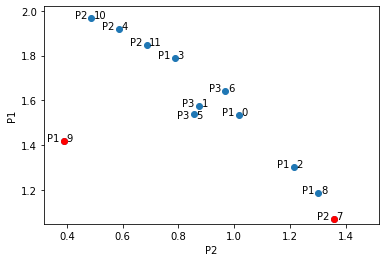

In [163]:
import matplotlib.pyplot as plt

n = 12
val = ans[:n]
fs_idx = val[(round(ans.P1,3) != 0.5) & (round(ans.P2,3) != 0.375) & (round(ans.P3,3) != 0.45)].index.to_numpy()
fig, ax = plt.subplots()
x = val['P2'].to_numpy()
y = val['P1'].to_numpy()
ax.scatter(x,y)
ax.set_ylabel('P1')
ax.set_xlabel('P2')
ax.set_xlim([fva.loc['P2'].minimum-0.07, fva.loc['P2'].maximum+0.02])
ax.set_ylim([fva.loc['P1'].minimum-0.02, fva.loc['P1'].maximum+0.02])
for i,txt in enumerate(val.index.to_numpy()):
    if (np.all(i != fs_idx)):
        ax.scatter(x[i], y[i], color='r')
    if(txt == 5):
        ax.annotate(txt,(x[i]+0.007,y[i]-0.02))
        ax.annotate(var_p[i],(x[i]-0.06,y[i]-0.02))
    else:
        ax.annotate(txt,(x[i]+0.009,y[i]))
        ax.annotate(var_p[i],(x[i]-0.06,y[i]))
fig.savefig('P2-P1', dpi=500)

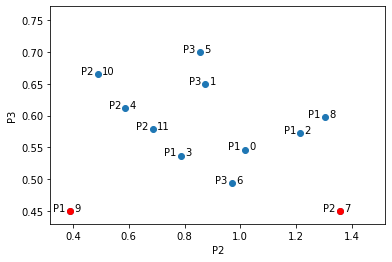

In [149]:
n = 12
val = ans[:n]
fs_idx = val[(round(ans.P1,3) != round(fva['minimum'].P1,3)) & (round(ans.P2,3) != round(fva['minimum'].P2,3)) & (round(ans.P3,3) != round(fva['minimum'].P3,3))].index.to_numpy()
fig, ax = plt.subplots()
x = val['P2'].to_numpy()
y = val['P3'].to_numpy()
ax.scatter(x,y)
ax.set_ylabel('P3')
ax.set_xlabel('P2')
ax.set_xlim([fva.loc['P2'].minimum-0.07, fva.loc['P2'].maximum+0.02])
ax.set_ylim([fva.loc['P3'].minimum-0.02, fva.loc['P3'].maximum+0.02])
for i,txt in enumerate(val.index.to_numpy()):
    if (np.all(i != fs_idx)):
        ax.scatter(x[i], y[i], color='r')
#         ax.annotate(txt, (x[i]+0.007, y[i]+0.007) )
#     else:
#         ax.annotate(txt,(x[i]+0.007,y[i]+0.007))
    ax.annotate(txt,(x[i]+0.015,y[i]))
    ax.annotate(var_p[i],(x[i]-0.06,y[i]))
fig.savefig('P2-P3', dpi=500)

In [169]:
#Case study: showing progression of gapsplit; Points on a straight line when only primary variable is used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

#Gen
xls = pd.ExcelFile('C:/Users/abuga/OneDrive/Desktop/PhD/Progress/Papers/Power_Tech_Conference/Excel data/case_study/pri_sec.xlsx')

valid = pd.read_excel(xls,'valid0')
pri = pd.read_excel(xls,'Primary0')

#Plot
n = 150
val = valid[:n]
fs_idx = pri[:n][pri['pri'] == 'P1'].index
fs_idx_1 = pri[:n][pri['pri'] == 'Q3'].index
fig, ax = plt.subplots()
x = val['P1'].to_numpy()
y = val['Q3'].to_numpy()
ax.scatter(x,y)
ax.set_ylabel('Q3')
ax.set_xlabel('P1')

for i,txt in enumerate(val.index.to_numpy()):
    if (np.any(i == fs_idx)):
        ax.scatter(x[i], y[i], color='red')
    if (np.any(i == fs_idx_1)):
        ax.scatter(x[i], y[i], color='black')
#     ax.annotate(txt,(x[i]+0.015,y[i]))
#     ax.annotate(pri[i],(x[i]-0.06,y[i]))
fig.savefig('0-sec-150pts', dpi=500)

In [ ]:
#Case Study 3: Comparing gapsplit with conventional approaches >> Random sampling
import numpy.linalg as linalg
from scipy.stats import norm
import time
import numpy as np
import pandas as pd
import cmath
from pyomo.opt import SolverFactory
from pyomo.environ import *


# (a,b) kumaraswamy parameter, c = covariance, LB = Lower bound, UB = Upper bound
def kumaraswamymontecarlo(a, b, c, LB, UB, num_samples):
    num_variables = len(LB) 
    MLB = np.repeat(LB[:,np.newaxis], num_samples, 1)
    UBLB = UB-LB
    MUBLB = np.repeat(UBLB[:,np.newaxis], num_samples, 1)
    uncorrelated = np.random.standard_normal((num_variables, num_samples))
    cov = c * np.ones(shape = (num_variables,num_variables)) + (1-c)*np.identity(num_variables)   
    L = linalg.cholesky(cov)
    correlated = np.dot(L, uncorrelated)
    cdf_correlated = norm.cdf(correlated) 
    karamsy = pow((1-pow((1-cdf_correlated),(1/b))),(1/a))   
    #probabilities = a* *  
    MCM = MLB + np.multiply(karamsy,MUBLB)  
    return MCM  


# Default scenario
def _generate_sample(pg,qg,pd,qd):
        #Create a model
    model = ConcreteModel()

    model.IDX1 = range(gen_len)
    model.IDX2 = range(bus_len)
    model.Pg = Var(model.IDX2)
    model.Qg = Var(model.IDX2)
    model.t = Var(model.IDX2)
    model.v = Var(model.IDX2)
    
    #Create slack variables
    model.d1 = Var(model.IDX1)
    model.d2 = Var(model.IDX1)
    
     
    # Fix data from generated samples
    for i in model.IDX2:
        model.Pg[i].fix(0) 
        model.Qg[i].fix(0) 

    for i in model.IDX1:
        model.Pg[gen['bus'][i]-1].fix(pg[i])
        model.Qg[gen['bus'][i]-1].fix(qg[i])
    
    # declare constraints
    model.c = ConstraintList()

    for i in range(bus_len):
        model.c.add(expr = model.v[i] <= Vmax[i])
        model.c.add(expr = model.v[i] >= Vmin[i]) 
        
    for i in model.IDX1:
        model.c.add(expr = model.d1[i] <= Pmax[i]-pg[i])
        model.c.add(expr = model.d1[i] >= Pmin[i]-pg[i]) 
        model.c.add(expr = model.d2[i] <= Qmax[i]-qg[i])
        model.c.add(expr = model.d2[i] >= Qmin[i]-qg[i])

    #Bus voltage angle initial condition
    model.c.add(model.t[0] == 0)


    #Nodal equations
    count = 0
    for i in range(bus_len):
        if (np.any(gen['bus'].ravel()-1==[i])):
            holder1 = model.d1[count]
            holder2 = model.d2[count]
            count = count+1
        else:
            holder1 = 0
            holder2 = 0
        model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Pg[i] - holder1 + pd[i] == 0)
        model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Qg[i] - holder2 + qd[i] == 0)

    #Line flow constraints
    for i in range(len(branch)): 
        x = int(branch.loc[i]['fbus'])-1
        y = int(branch.loc[i]['tbus'])-1
        val = (branch.loc[i]['rateA']/100)
        if(val == 0):
            val = 100
   #    With phasor
        Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
        Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

        Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
        Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     


        model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
        model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)


 #Declare objective function
    model.cost = Objective( 
        expr = sum([model.d1[i]**2 for i in range(gen_len)]) + sum([model.d2[i]**2 for i in range(gen_len)]) 
    ) 

    # solve
    solution = SolverFactory('ipopt').solve(model)
   
    
    if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
        if(model.cost()  >= 0.0001):
#             result = np.array([(model.Pg[gen['bus'][i]-1].value + model.d1[i].value) for i in range(gen_len)]+[model.Qg[gen['bus'][i]-1].value for i in range(gen_len)])
#             result = model.cost()
            result = np.array([(model.Pg[gen['bus'][i]-1].value + model.d1[i].value) for i in range(gen_len)]+[(model.Qg[gen['bus'][i]-1].value + model.d2[i].value) for i in range(gen_len)])
            return result
        else:
            result = np.array([(model.Pg[gen['bus'][i]-1].value) for i in range(gen_len)]+[(model.Qg[gen['bus'][i]-1].value) for i in range(gen_len)])
            return result
        
    else:
        return np.array([1,1,1,1,1,1])


##

# xls = pd.ExcelFile('data/samples/August_report/r/load_distribution.xlsx')
# load_data = pd.read_excel(xls, '6bus_load')
# p_load = load_data[['PL%s' % (i+1) for i in range(bus_len)]]
# q_load = load_data[['QL%s' % (i+1) for i in range(bus_len)]]

#Define number of samples
n = 5000

#Generation data
from smt.sampling_methods import LHS
pg = np.array([[p['minimum']['P1'], p['maximum']['P1']], [p['minimum']['P2'], p['maximum']['P2']], [p['minimum']['P3'], p['maximum']['P3']]])
qg = np.array([[q['minimum']['Q1'], q['maximum']['Q1']], [q['minimum']['Q2'], q['maximum']['Q2']], [q['minimum']['Q3'], q['maximum']['Q3']]])
sampling_qg = LHS(xlimits=qg)
sampling_pg = LHS(xlimits=pg)
gen_active = sampling_pg(2*n)
gen_reactive = sampling_qg(2*n)

#load data
h = kumaraswamymontecarlo(a = 1.6, b = 2.8, c = 0.75, LB = (Pd - 0.5*Pd), UB = (Pd + 0.5*Pd), num_samples = 2*n)
_Pd = pd.DataFrame(h).T
_Qd = 0.15*_Pd

# samples = np.zeros((len(load_data), bus_len))
samples = np.array([0,0,0,0,0,0])
k = 0
inf_ = np.array([])

while(1):
    if (len(samples)-len(inf_)-1 == n):
        break
#   new_s = _generate_sample(p_load.iloc[i],q_load.iloc[i])
    new_s = _generate_sample(gen_active[k,:], gen_reactive[k,:], _Pd.iloc[k].to_numpy(), _Qd.iloc[k].to_numpy())
    if new_s is not None:
#         samples[k] = new_s
        samples = np.vstack((samples,new_s))
        k = k + 1
        if(np.all(new_s == 1)):
            inf_ = np.append(inf_,k)
        


samples = pd.DataFrame(samples).drop(0)
samples = samples.drop(inf_)
samples.columns = ['P1','P2','P3','Q1','Q2','Q3']
writer = pd.ExcelWriter('C:/Users/abuga/OneDrive/Desktop/PhD/Progress/Papers/Power_Tech_Conference/Excel data/case_study/gen_conventional_approach_lbl.xlsx')
samples.to_excel(writer,'default')
writer.save()

##Check
# for i in range((n)):
#     print((_generate_sample(samples.iloc[i][:3].to_numpy(),samples.iloc[i][3:].to_numpy(),_Pd.iloc[i].to_numpy(), _Qd.iloc[i].to_numpy())))

#Save generated load profiles
writer = pd.ExcelWriter('C:/Users/abuga/OneDrive/Desktop/PhD/Progress/Papers/Power_Tech_Conference/Excel data/case_study/load_conventional_approach_lbl.xlsx')
data = pd.concat([pd.DataFrame(_Pd),pd.DataFrame(_Qd)],axis=1)
data = data.drop(inf_)[:n]
data.columns = [i for i in range(2*bus_len)]
data.to_excel(writer,'6bus_load')
writer.save()

In [723]:
#Compare metrics ()
from scipy.spatial import ConvexHull
xls_g = pd.ExcelFile('data/samples/August_report/r/samples_distribution.xlsx')
dist_gen = pd.read_excel(xls_g, 'valid')
interval = 1000

#Min cost generation data (SOA)
data = samples
variables = ['P1','Q2', 'Q3']
points = data[variables].to_numpy()

graph_hull_soa = np.zeros(interval)


for i in range(interval):
    space = int((i+1)*(len(data)/interval))
    #Convex hull volume
    graph_hull_soa[i] = ConvexHull(points[:space]).volume


In [724]:
#Compare metrics ()
#gen data from active load sampling (gapsplit)

# data = dist_gen[:len(samples)]
data = dist_gen
points = data[variables].to_numpy()

graph_hull_gap = np.zeros(interval)

for i in range(interval):
    space = int((i+1)*(len(data)/interval))
    #Convex hull volume
    graph_hull_gap[i] = ConvexHull(points[:space]).volume

In [739]:
frame = pd.concat([pd.DataFrame(graph_hull_gap),pd.DataFrame(graph_hull_soa)],axis=1)
writer = pd.ExcelWriter('C:/Users/abuga/OneDrive/Desktop/PhD/Progress/Papers/Power_Tech_Conference/Excel data/case_study/hull_SOA_GAP.xlsx')
frame.columns = ['Gap','SOA']
frame.to_excel(writer,'Hull volume')
writer.save()

In [742]:
(graph_hull_gap[-1] - graph_hull_soa[-1])/graph_hull_soa[-1]

0.14795904385931344

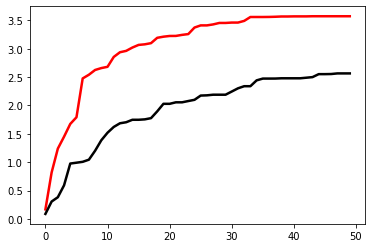

In [728]:
n = 50
plt.plot(graph_hull_gap[:n], color='red',lw=2.5)
plt.plot(graph_hull_soa[:n],color='black',lw=2.5)
plt.savefig('SOA-gap-comp-250',dpi=500)

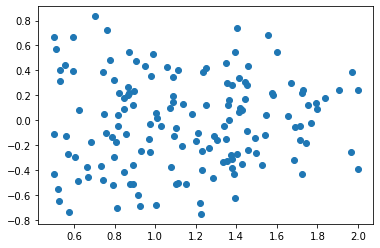

In [756]:
##Creating similar figures as 6&7 for soa
n= 150
plt.scatter(samples['P1'][:n],samples['Q3'][:n])

In [698]:
# #(Confirmation of feasibility)
# def _generate_sample(pg,qg,pd,qd):
#         #Create a model
#     model = ConcreteModel()

#     model.IDX1 = range(gen_len)
#     model.IDX2 = range(bus_len)
#     model.Pg = Var(model.IDX2)
#     model.Qg = Var(model.IDX2)
#     model.t = Var(model.IDX2)
#     model.v = Var(model.IDX2)
    
#     #Create slack variables
#     model.d1 = Var(model.IDX2)
#     model.d2 = Var(model.IDX2)
       
#     # Fix data from generated samples
#     for i in model.IDX2:
#         model.Pg[i].fix(0) 
#         model.Qg[i].fix(0) 

#     for i in model.IDX1:
#         model.Pg[gen['bus'][i]-1].fix(pg[i])
#         model.Qg[gen['bus'][i]-1].fix(qg[i])
    
#     # declare constraints
#     model.c = ConstraintList()

#     for i in range(bus_len):
#         model.c.add(expr = model.v[i] <= Vmax[i])
#         model.c.add(expr = model.v[i] >= Vmin[i]) 
        
#     #Bus voltage angle initial condition
#     model.c.add(model.t[0] == 0)


#     #Nodal equations
#     for i in range(bus_len):
#         model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Pg[i] + pd[i] == model.d1[i])
#         model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Qg[i] + qd[i] == model.d2[i])

#     #Line flow constraints
#     for i in range(len(branch)): 
#         x = int(branch.loc[i]['fbus'])-1
#         y = int(branch.loc[i]['tbus'])-1
#         val = (branch.loc[i]['rateA']/100)
#         if(val == 0):
#             val = 100
#    #    With phasor
#         Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
#         Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

#         Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
#         Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     


#         model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
#         model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)


#  #Declare objective function
#     model.cost = Objective( 
#         expr = sum([model.d1[i]**2 for i in range(gen_len)]) + sum([model.d2[i]**2 for i in range(gen_len)]) 
#     ) 

#     # solve
#     solution = SolverFactory('ipopt').solve(model)
   
    
#     if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
#         if(model.cost()  >= 0.0001):
# #             result = np.array([(model.Pg[gen['bus'][i]-1].value + model.d1[i].value) for i in range(gen_len)]+[model.Qg[gen['bus'][i]-1].value for i in range(gen_len)])
#             result = model.cost()
# #             result = np.array([(model.Pg[gen['bus'][i]-1].value + model.d1[i].value) for i in range(gen_len)]+[(model.Qg[gen['bus'][i]-1].value + model.d2[i].value) for i in range(gen_len)])
#             return result
#         else:
#             result = 0
# #             result = model.cost()
# #             result = np.array([(model.Pg[gen['bus'][i]-1].value) for i in range(gen_len)]+[(model.Qg[gen['bus'][i]-1].value) for i in range(gen_len)])
#             return result
        
#     else:
#         return np.array([1,1,1,1,1,1])
# #Check
# n=len(samples)
# for i in range((n)):
#     if((_generate_sample(samples.iloc[i][:3].to_numpy(),samples.iloc[i][3:].to_numpy(),_Pd.iloc[i].to_numpy(), _Qd.iloc[i].to_numpy())) != 0):
#         print("help")


In [127]:
#Case Study: Computing labels, measuring imbalances for different contingencies
# Define label generation function
def label(idx, line, dist = False):
    
    import pyomo.environ as pyo
    from pyomo.opt import SolverFactory
    #Create a model
    model = pyo.ConcreteModel()

    model.IDX1 = range(gen_len)
    model.IDX2 = range(bus_len)
    model.Pg = pyo.Var(model.IDX2)
    model.Qg = pyo.Var(model.IDX2)
    model.t = pyo.Var(model.IDX2)
    model.v = pyo.Var(model.IDX2)
    
    base = 100
    # Either for Sampling load from a distribution or static load
    if (dist):
        for i in range(bus_len):
            Pd[i] = load_data[['PL%s' % (i+1) for i in range(bus_len)]].loc[idx][i]
            Qd[i] = load_data[['QL%s' % (i+1) for i in range(bus_len)]].loc[idx][i]
    else:
        for i in range(bus_len):
            Pd[i] = bus['Pd'][i]/base
            Qd[i] = bus['Qd'][i]/base
     
    # Fix data from generated samples
    for i in model.IDX2:
        model.Pg[i].fix(0) 
        model.Qg[i].fix(0) 

    for i in model.IDX1:
        model.Pg[gen['bus'][i]-1].fix(gen_data[['P%s' % (i+1) for i in range(gen_len)]].loc[idx][i])
        model.Qg[gen['bus'][i]-1].fix(gen_data[['Q%s' % (i+1) for i in range(gen_len)]].loc[idx][i])

    #Create slack variables
    model.d1 = pyo.Var(model.IDX2)
    model.d2 = pyo.Var(model.IDX2)
    
    #Generator corrective actions
    model.d3 = pyo.Var(model.IDX2)
    model.d4 = pyo.Var(model.IDX2)
    
    for i in model.IDX2:
        model.d3[i].fix(0) 
        model.d4[i].fix(0) 
    for i in model.IDX1:
        model.d3[gen['bus'][i]-1].fixed = False
        model.d4[gen['bus'][i]-1].fixed = False
    
    # declare constraints
    model.c = pyo.ConstraintList()

    for i in range(bus_len):
        model.c.add(expr = model.Pg[i] + model.d3[i] <= Pmax[i])
        model.c.add(expr = model.Pg[i] + model.d3[i] >= Pmin[i])
        model.c.add(expr = model.Qg[i] + model.d4[i] <= Qmax[i])
        model.c.add(expr = model.Qg[i] + model.d4[i] >= Qmin[i])
        model.c.add(expr = model.v[i] <= Vmax[i])
        model.c.add(expr = model.v[i] >= Vmin[i])    

    #Bus voltage angle initial condition
    model.c.add(model.t[0] == 0)


    #Nodal equations
    for i in range(bus_len):
        model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Pg[i] + model.d3[i] + Pd[i]  == model.d1[i])
        model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Qg[i] + model.d4[i] + Qd[i]  == model.d2[i])


    #Line flow constraints
    for i in range(len(branch)): 
        x = int(branch.loc[i]['fbus'])-1
        y = int(branch.loc[i]['tbus'])-1
        val = (branch.loc[i]['rateA']/base)
        if(val == 0):
            val = 100
    #    With phasor
        Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
        Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

        Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
        Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     
        
        #Line disconnection cases; N-1
        if (i == line):
            model.c.add(expr = Pxy == 0)
            model.c.add(expr = Qxy == 0)
            model.c.add(expr = Pyx == 0)
            model.c.add(expr = Qyx == 0)
#         else:
        model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
        model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)

    #Declare objective function
    model.cost = pyo.Objective( 
        expr = sum([model.d1[i]**2 for i in range(bus_len)]) + sum([model.d2[i]**2 for i in range(bus_len)]) 
    ) 

    # solve
    solution = SolverFactory('ipopt').solve(model)#.write()
    
    if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
        return model.cost()
#         return Pd
#         return model.Pg[0].value

    else:
        return 'None'


In [ ]:
#Static load
# xls_g = pd.ExcelFile('data/samples/August_report/r/samples_distribution.xlsx')
xls_g = pd.ExcelFile('data/samples/August_report/static_samples_5000.xlsx')
load_data = pd.read_excel(xls_g, 'valid')

# n = len(load_data)
n = 1
labels = [np.zeros((n)) for i in range(len(branch))]
start_time = time.time()
for k in range(len(branch)):
    for i in range(len(load_data[:n])):
        labels[k][i] = label(idx=i,line=k)
end_time = time.time()        

cal_time = end_time-start_time
#     if(label(idx=i,line=l) >= 0.0001):
#         print(i,label(idx=i,line=l))

In [ ]:
#Gapsplit distribution
xls_g = pd.ExcelFile('data/samples/August_report/r/samples_distribution.xlsx')
xls_l = pd.ExcelFile('data/samples/August_report/r/load_distribution.xlsx')
gen_data = pd.read_excel(xls_g, 'valid')
load_data = pd.read_excel(xls_l,'6bus_load')
# n = len(load_data)
n = 2500
labels = [np.zeros((n)) for i in range(len(branch))]
start_time = time.time()
for k in range(len(branch)):
    for i in range(len(load_data[:n])):
        labels[k][i] = label(idx=i,line=k,dist=True)
end_time = time.time()        

cal_time = end_time-start_time
pd.DataFrame(labels).T

In [131]:
#SOA distribution
xls_g = pd.ExcelFile('C:/Users/abuga/OneDrive/Desktop/PhD/Progress/Papers/Power_Tech_Conference/Excel data/case_study/gen_conventional_approach_lbl.xlsx')
xls_l = pd.ExcelFile('C:/Users/abuga/OneDrive/Desktop/PhD/Progress/Papers/Power_Tech_Conference/Excel data/case_study/load_conventional_approach_lbl.xlsx')
gen_data = pd.read_excel(xls_g, 'valid')
load_data = pd.read_excel(xls_l,'6bus_load')
# n = len(load_data)
n = 2500
labels = [np.zeros((n)) for i in range(len(branch))]
start_time = time.time()
for k in range(len(branch)):
    for i in range(len(load_data[:n])):
        labels[k][i] = label(idx=i,line=k,dist=True)
end_time = time.time()        

cal_time = end_time-start_time
pd.DataFrame(labels).T

,0,1,2,3,4,5,6,7,8,9,10
0,1.316746,1.049715,0.630315,2.517664e-04,0.369914,0.199226,0.106367,5.237126e-15,0.001017,0.010340,1.513681e-04
1,0.484700,1.817602,1.528729,9.632286e-02,0.044779,0.590484,0.684234,3.881474e-14,0.109156,0.080349,2.142295e-02
2,1.019972,1.363256,0.875031,3.271582e-02,0.116324,0.388532,0.223486,3.476566e-03,0.071368,0.072423,3.553620e-14
3,0.173148,0.371044,0.165491,7.649306e-03,0.185261,0.395603,0.189130,3.964108e-15,0.002322,0.017750,5.390112e-16
4,0.936501,2.518152,1.994090,4.598980e-03,0.005167,0.091999,0.208610,1.233555e-16,0.000117,0.041420,1.149154e-12
...,...,...,...,...,...,...,...,...,...,...,...
2495,0.611699,1.215123,0.841997,5.592893e-03,0.031471,0.075970,0.235534,2.519567e-15,0.028635,0.052474,1.632506e-02
2496,0.003550,0.084969,0.076911,9.476183e-04,0.081685,0.096750,0.097137,7.737928e-03,0.053594,0.006097,1.767960e-14
2497,0.788181,0.578971,0.319943,3.209467e-04,0.411318,0.262546,0.093740,4.107470e-15,0.000540,0.000553,7.412684e-15
2498,0.002336,0.313403,0.353391,2.519072e-02,0.067063,0.273070,0.337524,7.969860e-16,0.008424,0.046854,1.514921e-13


In [138]:
# z = pd.DataFrame(labels).T<= 0.1
for i in range(len(branch)):
    if(len(z[i].value_counts()) == 2):
        print(z[i].value_counts().loc[True]/(z[i].value_counts().loc[True]+z[i].value_counts().loc[False]))

0.426
0.0504
0.044
0.7572
0.53
0.2204
0.1648
0.9164
0.7224
0.796
0.9964


In [134]:
np.std([0.426, 0.0504, 0.044, 0.7572, 0.53, 0.2204, 0.1648, 0.9164, 0.7224, 0.796, 0.9964])

0.33420476328390786

In [101]:
np.std([0.4284, 0.1448, 0.114, 0.6608, 0.2532, 0.1104, 0.1688, 0.7616, 0.2864, 0.6376, 0.948])

0.28185326702422914

In [139]:
# y = pd.DataFrame(labels).T<= 0.1
for i in range(len(branch)):
    if(len(y[i].value_counts()) == 2):
        print(y[i].value_counts().loc[True]/(y[i].value_counts().loc[True]+y[i].value_counts().loc[False]))

0.4284
0.1448
0.114
0.6608
0.2532
0.1104
0.1688
0.7616
0.2864
0.6376
0.948


In [24]:
x = pd.DataFrame(labels).T <=0.1
x[9].value_counts()

True     1296
False    1204
Name: 9, dtype: int64

In [ ]:
for i in range(len(branch)):
    print(x[i].value_counts())

In [56]:
for i in range(len(branch)):
    if(len(x[i].value_counts()) == 2):
        print(x[i].value_counts().loc[True]/(x[i].value_counts().loc[True]+x[i].value_counts().loc[False]))

0.2972
0.6632
0.3564
0.9484
0.5184
0.9836


In [65]:
np.std([0.2972,
0.6632,
0.3564,
0.9484,
0.5184,
0.9836,0,0,0,0,0])

0.36935937929661433

In [135]:

writer = pd.ExcelWriter('C:/Users/abuga/OneDrive/Desktop/PhD/Progress/Papers/Power_Tech_Conference/Excel data/case_study/soa_distribution_labels.xlsx')
(pd.DataFrame(labels).T <=0.1).to_excel(writer,'valid')
(pd.DataFrame(labels).T).to_excel(writer,'valid1')
writer.save()